# LSTM + AE



# [1] 쉬운 예제

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터셋

In [2]:
# 간단한 데이터 생성
x = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()
y = np.zeros(9)

timesteps = x.shape[0]
n_features = x.shape[1]
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

### (3) 필요 함수들 생성

* 시계열 데이터 분석을 위한 전처리(for LSTM, CNN)

In [3]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1 ):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

## 2.데이터 준비
* 3차원 데이터셋으로 만들어 봅시다.

In [4]:
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [8]:
timesteps = 3
x1, y1 = temporalize(x, y, timesteps)

In [9]:
x1.shape, y1.shape

((7, 3, 2), (7,))

In [10]:
x1

array([[[0.1  , 0.001],
        [0.2  , 0.008],
        [0.3  , 0.027]],

       [[0.2  , 0.008],
        [0.3  , 0.027],
        [0.4  , 0.064]],

       [[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

## 3.모델링 : LSTM+AE



In [11]:
x1.shape

(7, 3, 2)

In [12]:
n_features =  x1.shape[2] # 2

In [13]:
clear_session()

# Encoder - Decoder
lstm_ae = Sequential( [LSTM(128, input_shape = (timesteps, n_features), 
                            return_sequences=True),
                       LSTM(64, return_sequences=False),
                       RepeatVector(timesteps),
                       LSTM(64, return_sequences=True),
                       LSTM(128, return_sequences=True),
                       TimeDistributed(Dense(n_features))])

# input_layer = Input(shape=(timesteps, n_features))
# encoder = LSTM(128, return_sequences=True)(input_layer)
# encoder = LSTM(64, return_sequences=False)(encoder)
# encoder = RepeatVector(timesteps)(encoder)

# # Decoder
# decoder = LSTM(64, return_sequences=True)(encoder)
# decoder = LSTM(128, return_sequences=True)(decoder)
# decoder = TimeDistributed(Dense(n_features))(decoder)
# lstm_ae = Model(inputs=input_layer, outputs=decoder)

lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 3, 2)             258       
 ibuted)                                                

In [14]:
lstm_ae.compile(optimizer='adam', loss = 'mse')
lstm_ae.fit(x1, x1, epochs=50, batch_size=5, verbose=0)

pred = lstm_ae.predict(x1)
print('---Predicted---')
print(np.round(pred,3))
print('---Actual---')
print(np.round(x1, 3))

1/1 [==============================] - 1s 884ms/step
---Predicted---
[[[ 0.185  0.015]
  [ 0.268  0.008]
  [ 0.313 -0.005]]

 [[ 0.222  0.032]
  [ 0.332  0.044]
  [ 0.387  0.047]]

 [[ 0.271  0.056]
  [ 0.41   0.092]
  [ 0.474  0.115]]

 [[ 0.337  0.089]
  [ 0.506  0.158]
  [ 0.574  0.206]]

 [[ 0.426  0.137]
  [ 0.623  0.249]
  [ 0.683  0.328]]

 [[ 0.545  0.206]
  [ 0.755  0.372]
  [ 0.792  0.487]]

 [[ 0.696  0.302]
  [ 0.887  0.529]
  [ 0.886  0.681]]]
---Actual---
[[[0.1   0.001]
  [0.2   0.008]
  [0.3   0.027]]

 [[0.2   0.008]
  [0.3   0.027]
  [0.4   0.064]]

 [[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


-------

# [2] pulp-and-paper mill 공정 데이터

## 1.환경준비

### (1) 라이브러리 로딩

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요 함수들 생성

#### 1) reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [10]:
def recon_err_plot(x, x_pred, y, threshold=0):
    mse = np.mean(np.power(x.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots(figsize=(15, 8))
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Break" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error plot")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.grid()
    plt.show()

    return error_df

#### 2) precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [11]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (12,8))

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### 3) threshold로 잘랐을 때, 분류 평가 함수


In [12]:
def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return confusion_matrix(y, pred_temp)

#### 4) DL 학습곡선 그리기


In [13]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

#### 5) 시계열 데이터 분석을 위한 데이터구조 만들기(for LSTM, CNN)

In [14]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

### (3) 데이터셋 불러오기

In [15]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


In [16]:
data['y'].value_counts()

0.0    18027
1.0      247
Name: y, dtype: int64

## 2.데이터 준비

### (1) 불필요한 변수 제거

불필요한 변수 제거 : time

In [16]:
data.drop('time', axis=1, inplace=True)

In [17]:
data.shape

(18274, 60)

### (2) x,y 분할

* x, y 분리

In [18]:
target = 'y'
input_x = data.drop(target, axis = 1).values
input_y = data['y'].values

In [ ]:
input_x.shape

### (3) 스케일링

In [19]:
scaler = MinMaxScaler()
input_x = scaler.fit_transform(input_x)

### (4) 3차원 데이터로 변환
* timestep에 맞게 data point를 2차원으로 변환  
(data point : 2차원 ==> data set : 3차원)

In [20]:
timestep = 10 
x, y = temporalize(input_x, input_y, timestep)

In [ ]:
x.shape, y.shape

### (5) 데이터셋 분할

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=6000, random_state=20)

### (6) Normal 분리 : Normal 데이터로만 학습하기 위해서 

In [23]:
x_train0 = x_train[y_train==0]
x_train0.shape

(12093, 10, 59)

## 3.모델링



### (1) LSTM + AE ①
* 다음과 같이 구조를 정의하시오.
    * lstm(64)
    * lstm(32)
    * RepeatVector(  )
    * lstm(32)
    * lstm(64)
    * TimeDistributed(Dense(  ))

* 모델이름 : model1


In [25]:
n_features = x_train0.shape[2] # 59
timesteps =  x_train0.shape[1] # 10

In [26]:
model1 = Sequential( [LSTM(64, input_shape = (timesteps, n_features), 
                            return_sequences=True),
                       LSTM(32, return_sequences=False),
                       RepeatVector(timesteps),
                       LSTM(32, return_sequences=True),
                       LSTM(64, return_sequences=True),
                       TimeDistributed(Dense(n_features))])


* 학습
    * epochs : 50~100

In [ ]:
model1.compile(optimizer = 'adam', loss = 'mse')
hist = model1.fit(x= x_train0,y = x_train0, epochs = 50, validation_split= .2).history

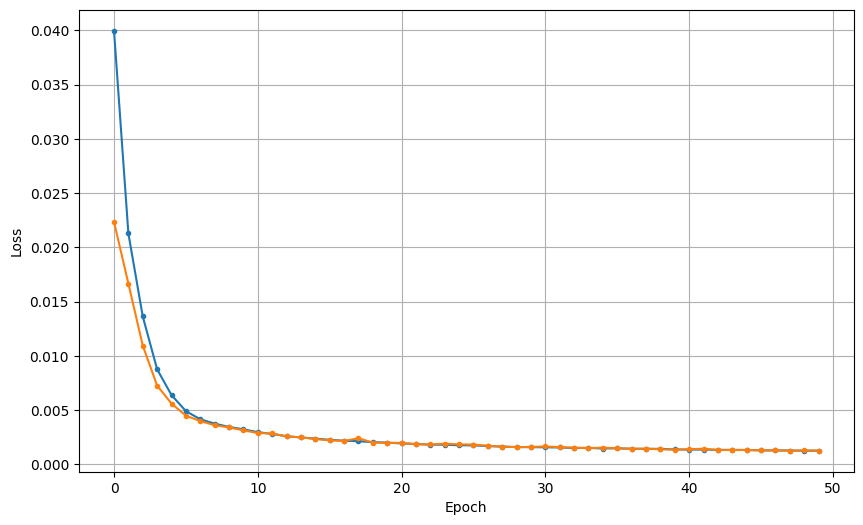

In [28]:
plot_learning_curve(hist)

### (2) LSTM + AE ②
* RepeatVector 제외 모델
* 1번과 동일한 구조로 모델링을 수행하되, RepeatVector를 제외하고 수행합니다.
* RepeatVector를 제외하게 되면 바로 전 LSTM 층에서, return_sequences = True 이어야 합니다.
* 모델이름 : model2


In [ ]:
n_features = x_train0.shape[2] # 59
timesteps =  x_train0.shape[1] # 10

In [29]:
model2 = Sequential( [LSTM(64, input_shape = (timesteps, n_features), 
                            return_sequences=True),
                       LSTM(32, return_sequences=True),
                       LSTM(32, return_sequences=True),
                       LSTM(64, return_sequences=True),
                       TimeDistributed(Dense(n_features))])

* 학습
    * epochs : 50~100

In [30]:
model2.compile(optimizer = 'adam', loss = 'mse')
hist = model2.fit(x= x_train0,y = x_train0, epochs = 50, 
                  validation_split= .2, verbose = 0).history

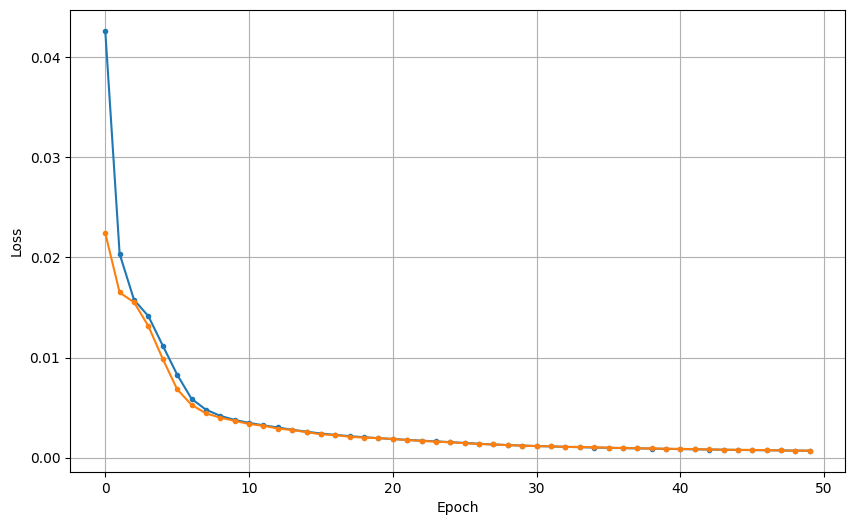

In [31]:
plot_learning_curve(hist)

### (3) 분류에 대한 평가

#### 1) LSTM + AE ①

* val 셋으로 예측하고 reconstruction error로 평가해 봅시다.

In [32]:
x_val.shape

(6000, 10, 59)

In [33]:
# predict
pred = model1.predict(x_val)

188/188 [==============================] - 2s 4ms/step


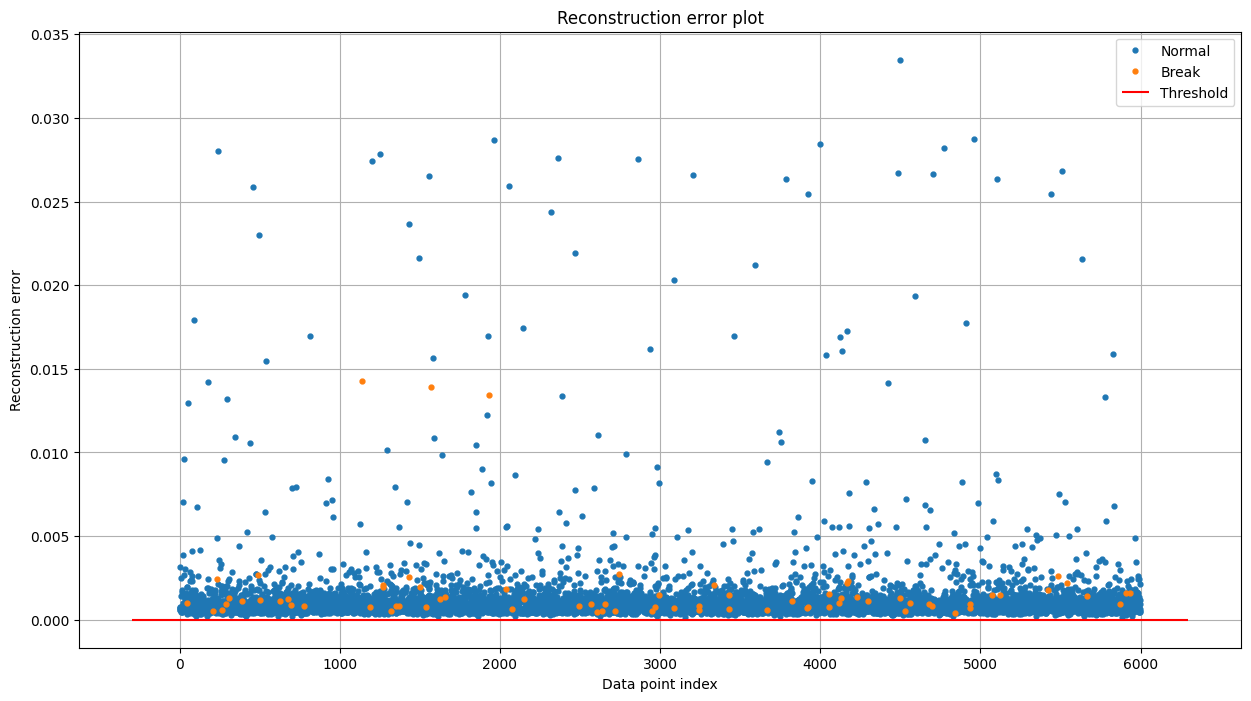

In [35]:
# Reconstruction Error 그래프를 그려 봅시다.
result = recon_err_plot(x_val, pred, y_val, threshold = 0)

In [36]:
result.head()

,index,Reconstruction_error,True_class
0,0,0.000723,0.0
1,1,0.000756,0.0
2,2,0.000683,0.0
3,3,0.000594,0.0
4,4,0.000555,0.0


* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-11-bab5292dc7b7>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


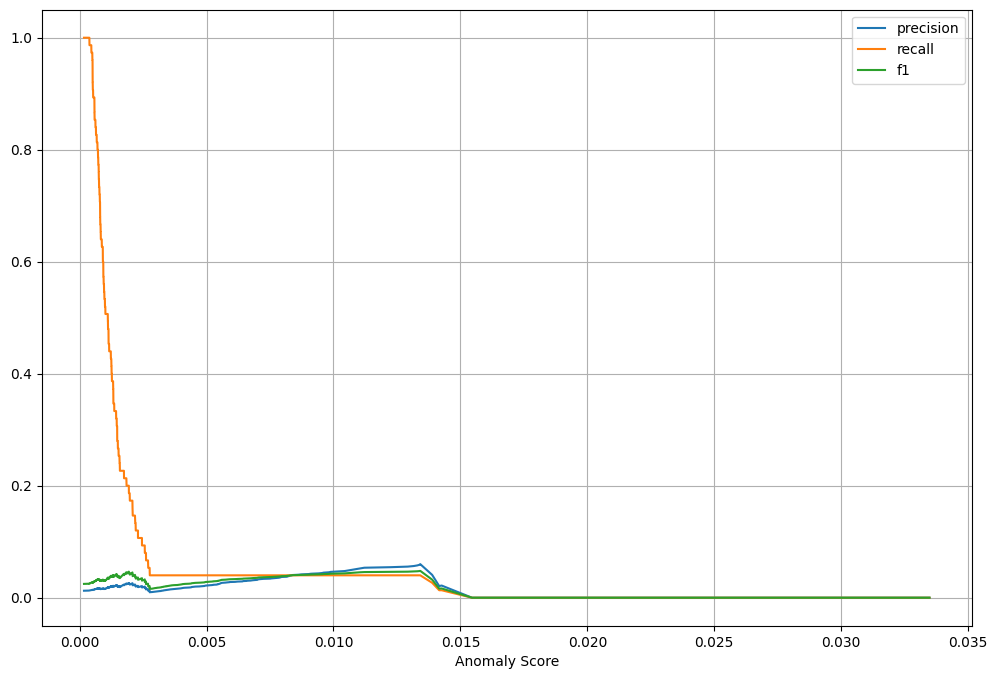

In [39]:
_, _, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [40]:
thresholds[np.argmax(f1)]

0.013418361808274352

In [41]:
classification_report2(result['True_class'], result['Reconstruction_error'], 0.0134)

< confusion matrix >

[[5878   47]
 [  72    3]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5925
         1.0       0.06      0.04      0.05        75

    accuracy                           0.98      6000
   macro avg       0.52      0.52      0.52      6000
weighted avg       0.98      0.98      0.98      6000



array([[5878,   47],
       [  72,    3]])

#### 2) LSTM + AE ②

* val 셋으로 예측하고 reconstruction error로 평가해 봅시다.

In [ ]:
x_val.shape

(6000, 10, 59)

In [42]:
# predict
pred = model2.predict(x_val)

188/188 [==============================] - 2s 4ms/step


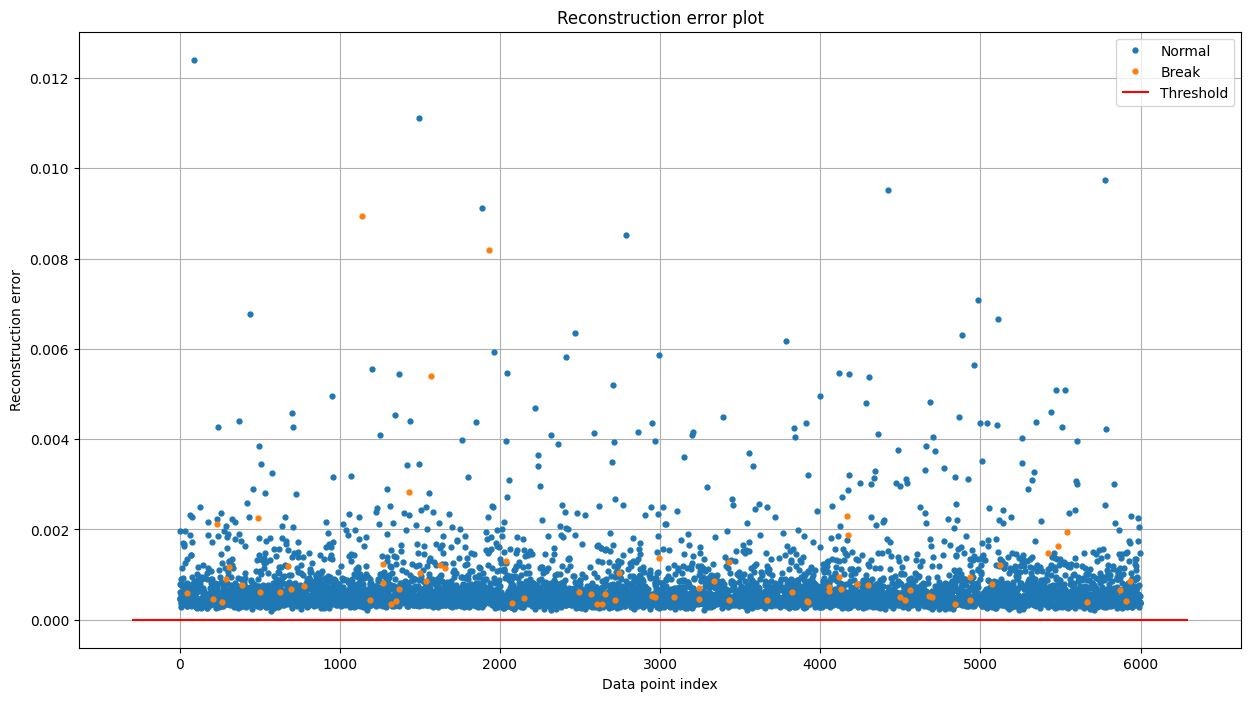

In [43]:
# Reconstruction Error 그래프를 그려 봅시다.
result = recon_err_plot(x_val, pred, y_val, threshold = 0)

In [ ]:
result.head()

,index,Reconstruction_error,True_class
0,0,0.000723,0.0
1,1,0.000756,0.0
2,2,0.000683,0.0
3,3,0.000594,0.0
4,4,0.000555,0.0


* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-11-bab5292dc7b7>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


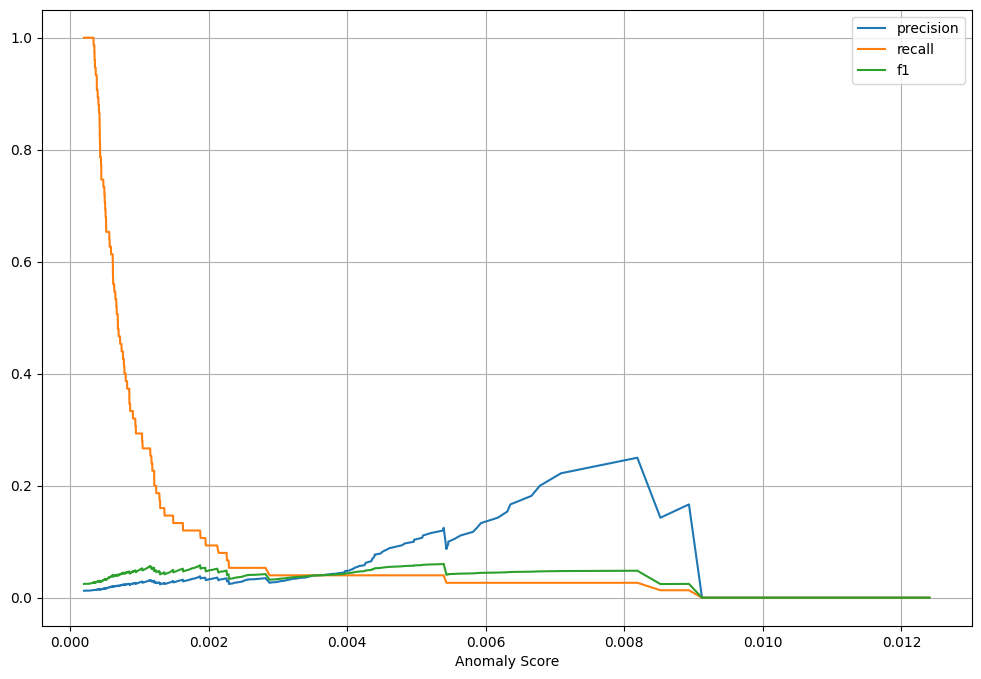

In [44]:
_, _, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [46]:
cutoff = thresholds[np.argmax(f1)]

In [47]:
classification_report2(result['True_class'], result['Reconstruction_error'], cutoff)

< confusion matrix >

[[5904   21]
 [  73    2]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5925
         1.0       0.09      0.03      0.04        75

    accuracy                           0.98      6000
   macro avg       0.54      0.51      0.52      6000
weighted avg       0.98      0.98      0.98      6000



array([[5904,   21],
       [  73,    2]])